In [2]:
from blochK import Hamiltonian2D
import numpy as np
from numpy import pi,cos,sin,exp

import matplotlib.pyplot as plt

# Defining a Hamiltonian

Let's define a Hamiltonian. Its core structure is a Hamiltonian function which takes kx,ky (ndarray) and maps it to a ndarray with shape (n_orbitals,n_orbitals,*kx.shape). It should be hermitian in the first two axis.

In [23]:
def Hsquare_fct(kx,ky,t=1,mu=-1,m=0): 
    """
    t: NN hopping 
    mu: chemical potential
    m: FM
    """
    Hk = np.zeros((2,2,*kx.shape),dtype=complex) #Basis (up,down)

    #set hamiltonian structure
    Hk[0,0] = -2*t*cos(kx) - 2*t*cos(ky) - mu

    #make hermitian
    Hk[1,0] = np.conjugate(Hk[0,1])

    #spin degenerate
    Hk[1:,1:] = Hk[:1,:1]

    #add magnetization in z direction
    Hk[0,0] -= m
    Hk[1,1] += m

    return Hk

# Define the Hamiltonian as a Hamiltonian2D object
Hsquare = Hamiltonian2D(Hsquare_fct, basis_states=['up','down'], basis=['spin'], n1=np.array([1,0]), n2=np.array([0,1]))
#parameters like basis, basis_states, are optional but recommended for clarity
#n1,n2 define the Brillouin zone

#Hsquare has many parameters derived from the Hamiltonian function
print('number of orbitals: ', Hsquare.n_orbitals)
print('lattice vectors: ', Hsquare.n1, Hsquare.n2)

#You can define operators in which the Hamiltonian lives in
Hsquare.add_operator('spin', np.array([1,-1])) #diagnonal part of sz
print('spin operator: ', Hsquare.operator.spin)



number of orbitals:  2
lattice vectors:  [1 0] [0 1]
spin operator:  [ 1 -1]


The Brillouin zone of the Hamiltonian is defined automatically via n1 and n2

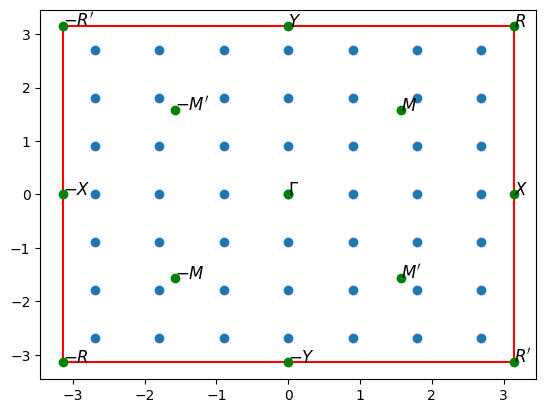

In [24]:
#we can sample the BZ
ks = Hsquare.BZ.sample(7) #sample the BZ with a 7x7 grid
plt.scatter(*ks)

#we can also get the boundary of the BZ
boundary = Hsquare.BZ.return_boundary(periodic=True)
plt.plot(*boundary.T, color='red')

#some high symmetry points which are useful for band structure plots
pts = Hsquare.BZ.points
for l, pt in pts.items():
    plt.plot([pt[0]], [pt[1]], 'go') #mark the point
    plt.text(*pt, r'${}$'.format(l), fontsize=12, ha='left', va='baseline')



# Getting the matrix and diagonalizing it

In [25]:
Hk = Hsquare.evaluate(*ks) #evaluate the Hamiltonian on the k-points
print('shape of Hk: ', Hk.shape) #shape is (n_orbitals, n_orbitals, *kx.shape)
print()

es,psi = Hsquare.diagonalize(*ks) #diagonalize the Hamiltonian
print('shape of es: ', es.shape) #shape is (n_bands, *kx.shape)
print('shape of psi: ', psi.shape) #shape is (n_bands, *kx.shape,n_orbitals, )
print()

#evaluting operators
import blochK.observable as observable
Hsquare.add_operator('project1', np.array([[1,0],[0,0]])) #projector on first basis state
project1 = observable.exp_value_O(Hsquare.operator.project1, psi)
print('shape of project1: ', project1.shape) #shape is (n_bands, n_bands, *kx.shape)
print('momentum sum of projector on first basis state: ', np.sum(project1,axis=(2,3))) #should be number of k-points in the [0.0] element.


shape of Hk:  (2, 2, 7, 7)

shape of es:  (2, 7, 7)
shape of psi:  (2, 7, 7, 2)

shape of project1:  (2, 2, 7, 7)
momentum sum of projector on first basis state:  [[49.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]


# Plotting

## Plotting the FS

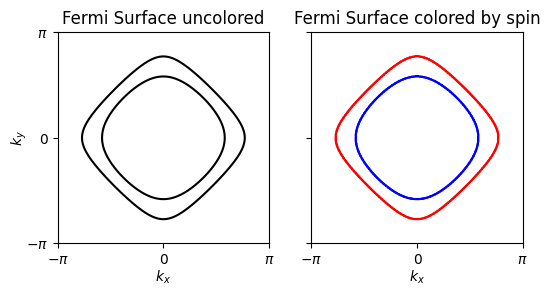

In [26]:
from blochK.plotting import plot_FS

Hsquare.set_params(dict(m=0.5)) #set parameters of Hamiltonian

fig,axs = plt.subplots(1,2, figsize=(6,3))

axs[0].set_title('Fermi Surface uncolored')
plot_FS(axs[0], Hsquare, Lk=100, coloring_operator='k')

axs[1].set_title('Fermi Surface colored by spin')
plot_FS(axs[1], Hsquare, Lk=100, coloring_operator=Hsquare.operator.spin,cmap='bwr',show_ylabel=False)

## Plotting the Band structure

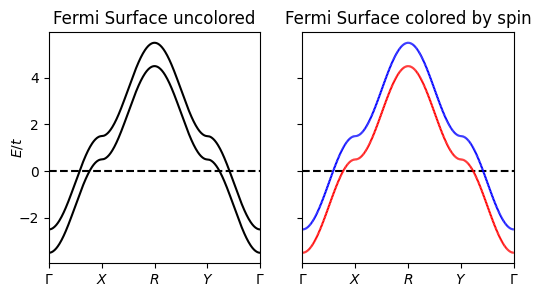

In [27]:
from blochK.plotting import plot_bandstruc


#define a path in the BZ
labels_points_path = ['\Gamma','X','R','Y','\Gamma'] #this is also the default
#the right points are automatically found from the BZ points

fig,axs = plt.subplots(1,2, figsize=(6,3))

axs[0].set_title('Fermi Surface uncolored')
plot_bandstruc(axs[0], Hsquare, N_samples=100, coloring_operator='k')

axs[1].set_title('Fermi Surface colored by spin')
plot_bandstruc(axs[1], Hsquare, N_samples=100,labels_points_path=labels_points_path, coloring_operator=Hsquare.operator.spin,cmap='bwr',show_ylabel=False)

# Computing observables

## Conductivity

The conductivity tensor

$\begin{pmatrix}
\sigma_{xx} & \sigma_{xy} \\
\sigma_{yx} & \sigma_{yy}
\end{pmatrix}
$

In [33]:
sigma = observable.conductivity(Hsquare)
print('sigma: \n', sigma)

sigma_spin = observable.conductivity(Hsquare,operator=Hsquare.operator.spin)
print('sigma_spin: \n', sigma_spin)

sigma: 
 [[ 4.44672275e+01 -2.26798918e-15]
 [-2.26798918e-15  4.44672275e+01]]
sigma_spin: 
 [[ 3.69764497e+01 -2.45087965e-15]
 [-2.45087965e-15  3.69764497e+01]]


We can also compute the conductivity orbital resolved. The axis are then (n_orbitals,direction1, direction2).

In [40]:
sigma_tensor = observable.conductivity_orbital_resolved(Hsquare)
print(sigma_tensor.shape)
print("If the first axis is contracted, we get the same results as above.")

print('sigma: \n', np.einsum('mij,m->ij',sigma_tensor,np.ones(2)))
print('sigma_spin: \n', np.einsum('mij,m->ij',sigma_tensor,Hsquare.operator.spin))

(2, 2, 2)
If the first axis is contracted, we get the same results as above.
sigma: 
 [[4.44672275e+01 2.41851941e-16]
 [2.41851941e-16 4.44672275e+01]]
sigma_spin: 
 [[3.69764497e+01 2.53340594e-16]
 [2.53340594e-16 3.69764497e+01]]
